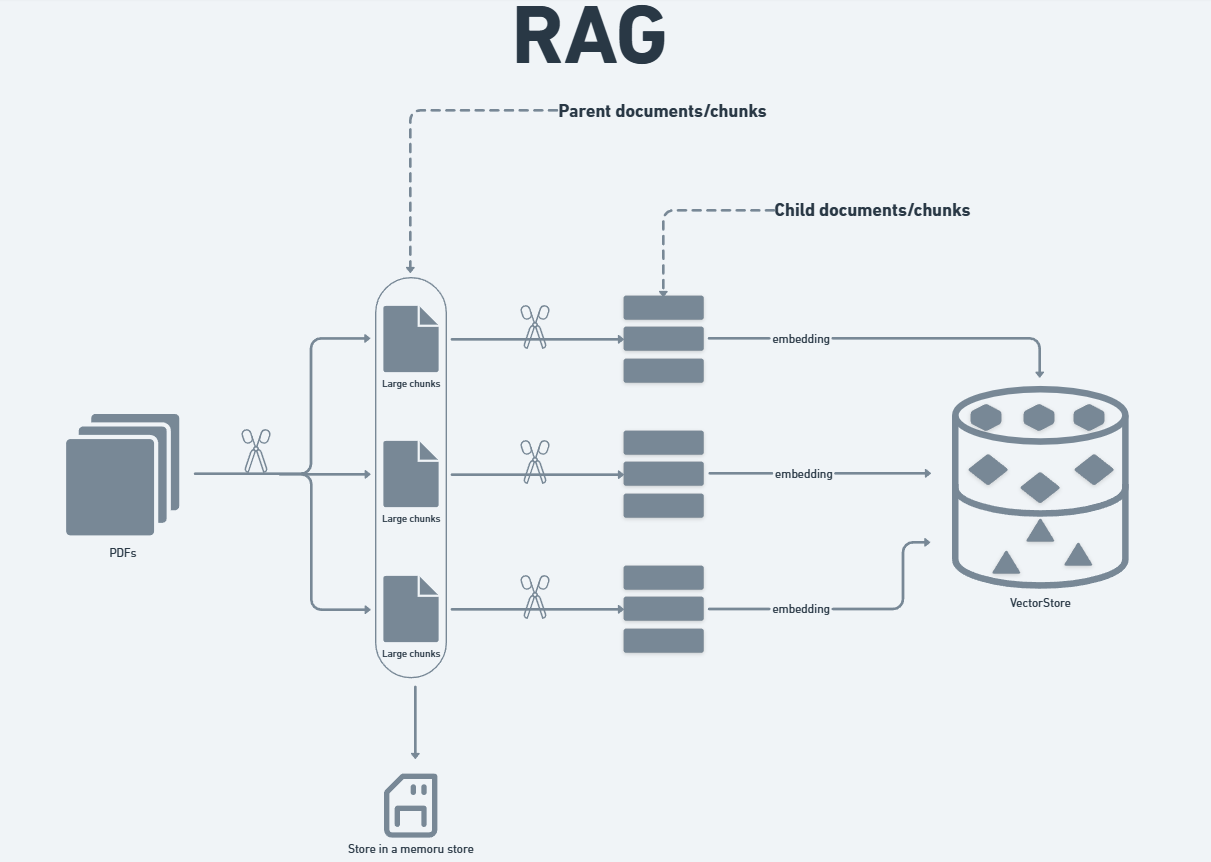

In [48]:
!pip install langchain
!pip install langchain-community
!pip install langchain-chroma
!pip install langchain-text-splitters

In [32]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain_core.output_parsers import StrOutputParser
import os

In [ ]:
os.environ['OPENAI_API_KEY'] = ''

In [7]:
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.0)

In [8]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [10]:
dir_doc_pdf = r"C:\\Users\\DioenD\\PycharmProjects\\Rocketseat\\ia-pra-devs\\rag-advanced\\court documents"

In [14]:
loader = PyPDFDirectoryLoader(dir_doc_pdf)

In [15]:
pages = loader.load_and_split()

In [16]:
len(pages)

5

### Separando os documentos em chunks

In [20]:
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

parent_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len,
    add_start_index = True
)

### Storages


In [ ]:
# storages
# vai salvar em memoria os documentos maiores
store = InMemoryStore()

In [22]:
# Chroma 
# vai armazenar no banco de vetores
vectorstore = Chroma(embedding_function=embeddings, persist_directory="child_vector_db")

C:\Users\DioenD\AppData\Local\Temp\ipykernel_36328\454150619.py:3: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(embedding_function=embeddings, persist_directory="child_vector_db")


### Retriever

In [23]:
parent_document_retriever = ParentDocumentRetriever(
    vectorstore=vectorstore, # onde estão os documentos mais curtos
    docstore=store, # onde estão os documentos maiores
    child_splitter=child_splitter,
    parent_splitter=parent_splitter
)

In [24]:
parent_document_retriever.add_documents(pages, ids=None)

In [ ]:
# visualizando so embeddings dos documentos child_splitter
parent_document_retriever.vectorstore.get()

{'ids': ['0058e426-714b-4b8c-8a3b-c5b4d569de78',
  '008ad25d-eed9-494b-aedd-d9d1cba83f4e',
  '01c24e8e-b374-4bf5-873e-06106e901f8d',
  '05b47ba0-f55b-4370-bd91-b0e39da57823',
  '0f87427d-0e25-431e-b7e5-59e768703a69',
  '10f2641f-e210-4456-9997-18f514781df5',
  '118643b3-ea34-41b9-82b4-ae6c17158ebe',
  '12f7b412-bd50-4d5c-9bc8-e9f88bfae723',
  '18abe403-2343-4dbd-9b8d-02521349150f',
  '18cf383e-69a4-41ca-aa98-2bbad1316ad0',
  '193ccab1-97b5-48cb-a05b-51f208bbc2e7',
  '1c5f9c9a-9f76-476a-a23c-92c3de205c41',
  '2052b967-a618-403f-aa0c-b1837f8b84ed',
  '211566a5-eb22-44f6-81d4-4671e97d6c07',
  '21694a9c-3c41-4743-81db-eb608f979ef2',
  '26306e77-9b3b-487e-b661-16fb40957382',
  '2749101d-aa8e-4cd7-a7d2-a2cec8a9457a',
  '2b3333ba-ee86-48dd-8214-c07e17c7b7e6',
  '2c96a4b7-c639-467f-a07f-3efd8871aac8',
  '2ed842e5-67a9-401d-9d84-0e0501198aef',
  '32733d53-30d7-4131-a8d4-98d2cc202890',
  '32eace6c-fc40-4444-b60f-49c2f6d5f5a7',
  '3445c1ef-530d-46d0-a3d4-89ca27108d2a',
  '382e7090-cb93-4c9a-acc3-

In [28]:
TEMPLATE = """
    Você é um especialista em legislação com seus mais de 50 anos atuando como advogado e com sua qualificação com doutorado na area 
    e deve auxiliar com consutorias em caso juridicos.
    Query: 
    {question}

    context:
    {context}
"""

In [29]:
rag_template = ChatPromptTemplate.from_template(template=TEMPLATE)

In [33]:
setup_retrival = RunnableParallel({
    "question": RunnablePassthrough(),
    "context": parent_document_retriever
})

In [34]:
output_parser = StrOutputParser()

In [35]:
parent_chain_retrival = setup_retrival | rag_template | llm | output_parser

In [36]:
parent_chain_retrival.invoke("Qual a decisão foi tomada no caso da Fraude Financeira ?")

'A decisão tomada no caso da Fraude Financeira foi a condenação do réu, Sr. João Francisco Almeida, a ressarcir a quantia de R$ 500.000 à Empresa Delta S.A., além de uma multa indenizatória no valor de R$ 100.000 por danos morais e materiais. Também foi ordenado o bloqueio de bens do réu até o pagamento integral.'

In [46]:
res = parent_chain_retrival.invoke("Me auxilie montando uma petição no caso Processo n.º 24680-90.2024.8.26.0000 preenchendo os dados do seus exemplo criado")

In [47]:
print(res)

Para montar a petição no caso do Processo n.º 24680-90.2024.8.26.0000, você pode seguir o exemplo abaixo:

---

**EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) DE DIREITO DA VARA CÍVEL DA COMARCA DE SÃO PAULO/SP**

**Ação de Ressarcimento por Fraude e Enriquecimento Ilícito**

**Autor: Empresa Delta S.A.**
**Réu: João Francisco Almeida, ex-diretor financeiro**

**Processo n.º 24680-90.2024.8.26.0000**

**Distribuição por Dependência ao Processo n.º [número do processo ao qual está vinculado, se houver]**

**Empresa Delta S.A.**, pessoa jurídica de direito privado, inscrita no CNPJ sob o nº [informar o CNPJ], com sede na [endereço completo], por seu advogado que esta subscreve, nos termos do art. 77, inciso V, do Código de Processo Civil, vem respeitosamente à presença de Vossa Excelência, propor a presente

**AÇÃO DE RESSARCIMENTO POR FRAUDE E ENRIQUECIMENTO ILÍCITO**

em face de **João Francisco Almeida**, brasileiro, estado civil, profissão, portador do RG nº [informar o RG] e do CPF